🚀 Full-Scale Benchmark Started on cuda

📂 No saved results found. Starting training...

📂 Processing Dataset: MNIST ...
   [Run 1/3] sigmoid... tanh... relu... leaky_relu... elu... silu... gelu... sinlu... oscillatory... 
   [Run 2/3] sigmoid... tanh... relu... leaky_relu... elu... silu... gelu... sinlu... oscillatory... 
   [Run 3/3] sigmoid... tanh... relu... leaky_relu... elu... silu... gelu... sinlu... oscillatory... 

📂 Processing Dataset: QMNIST ...
   [Run 1/3] sigmoid... tanh... relu... leaky_relu... elu... silu... gelu... sinlu... oscillatory... 
   [Run 2/3] sigmoid... tanh... relu... leaky_relu... elu... silu... gelu... sinlu... oscillatory... 
   [Run 3/3] sigmoid... tanh... relu... leaky_relu... elu... silu... gelu... sinlu... oscillatory... 

📂 Processing Dataset: EMNIST ...
   [Run 1/3] sigmoid... tanh... relu... leaky_relu... elu... silu... gelu... sinlu... oscillatory... 
   [Run 2/3] sigmoid... tanh... relu... leaky_relu... elu... silu... gelu... sinlu... oscillatory.

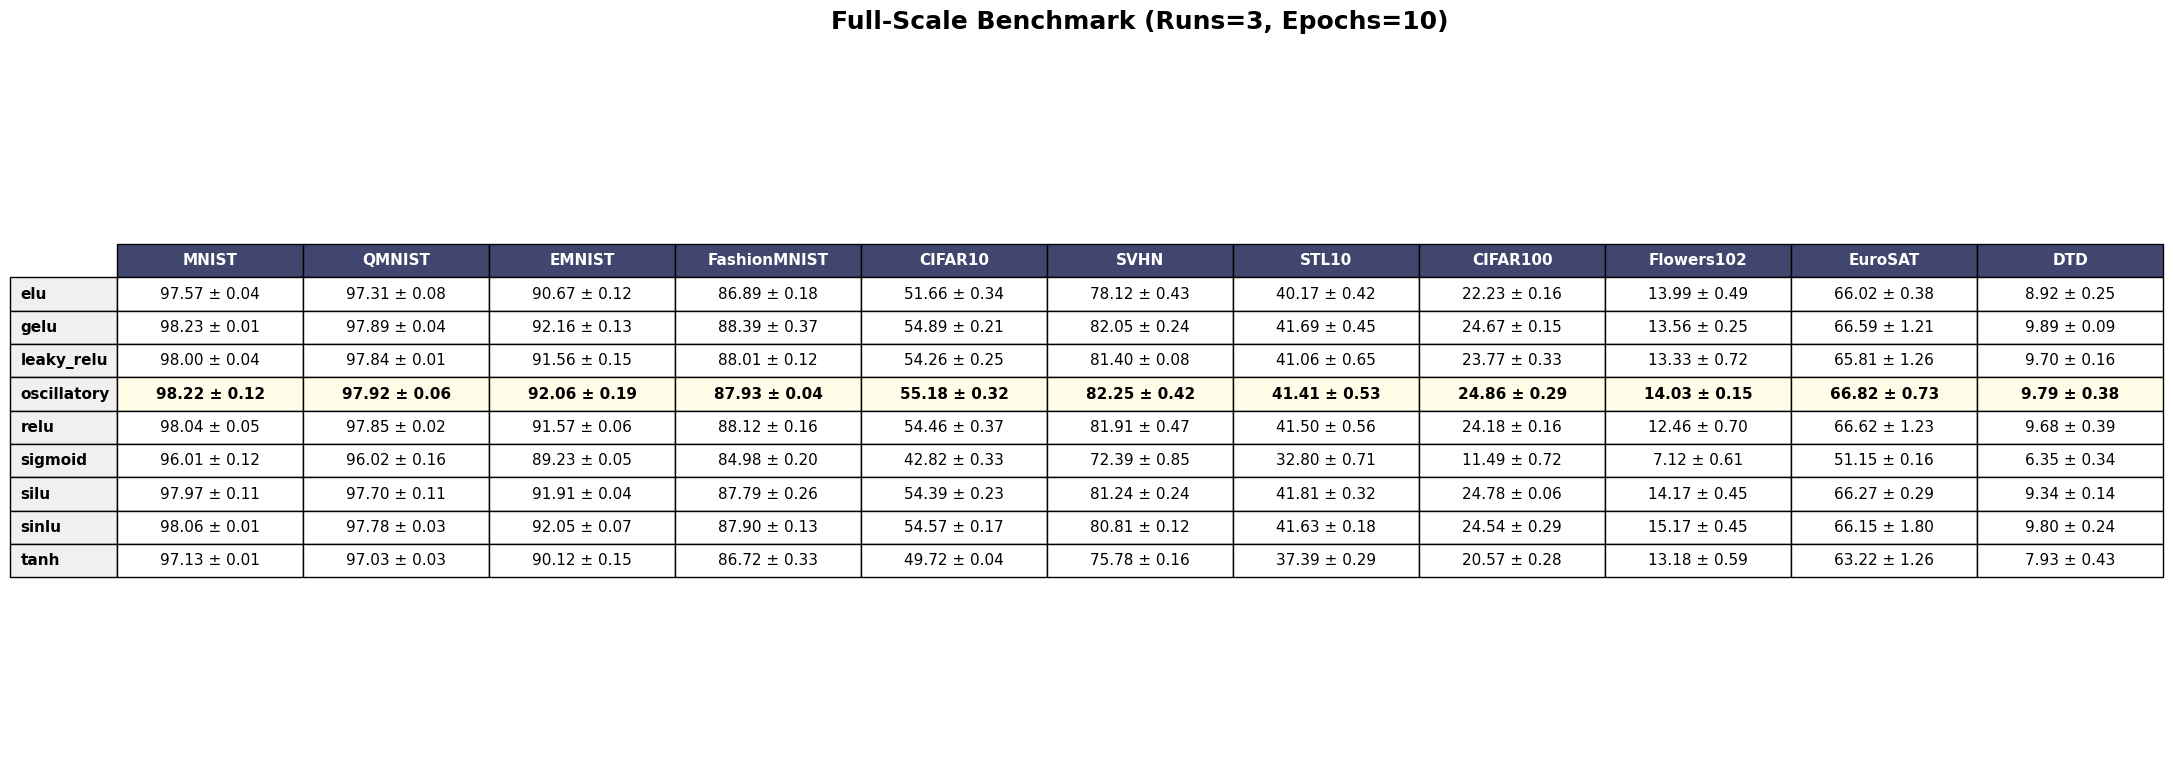

In [4]:
# ---------------------------------------------------------
# [1] 라이브러리 임포트 (Import Libraries)
# ---------------------------------------------------------
import torch  # 파이토치: 딥러닝 모델링 및 연산을 위한 핵심 프레임워크
import torch.nn as nn  # 신경망 모듈: 레이어, 손실 함수 등을 포함
import torch.optim as optim  # 최적화 모듈: Adam, SGD 등 가중치 업데이트 알고리즘
from torchvision import datasets, transforms  # 비전 데이터셋 및 이미지 전처리 도구
from torch.utils.data import DataLoader  # 데이터 로더: 배치 단위 데이터 공급기
import matplotlib.pyplot as plt  # 시각화: 그래프 및 표 그리기
import numpy as np  # 넘파이: 수치 연산 및 배열 처리
import pandas as pd  # 판다스: 데이터프레임(표) 생성 및 통계 처리
import warnings  # 경고 제어: 불필요한 로그 숨김
import time  # 시간: 학습 시간 측정 (현재 코드에선 미사용이나 습관적으로 포함)
import os  # OS: 파일 경로 확인 및 시스템 명령 수행 (파일 존재 여부 확인용)
import pickle  # 피클: 파이썬 객체(리스트, 딕셔너리 등)를 파일로 저장/로드하는 라이브러리

# 데이터셋 다운로드 시 발생하는 버전 관련 경고 등을 무시하여 콘솔을 깨끗하게 유지합니다.
warnings.filterwarnings("ignore")

# ---------------------------------------------------------
# [2] 활성화 함수 정의 (Custom Activation Functions)
# ---------------------------------------------------------

# (1) 제안 모델: Oscillatory Soft Gate
class OscillatorySoftGate(nn.Module):
    """ [Proposed] 제안하는 위상 적응형 활성화 함수 """
    def __init__(self, a=1.0, b=1.0):
        super(OscillatorySoftGate, self).__init__()
        # 학습 가능한 파라미터 a(진폭), b(주파수)를 정의합니다. 역전파로 값이 업데이트됩니다.
        self.a = nn.Parameter(torch.tensor(a))
        self.b = nn.Parameter(torch.tensor(b))

    def forward(self, x):
        # 수식: x * sigmoid(x + a * sin(b * x))
        # 게이트(Sigmoid) 내부를 사인파로 흔들어주어 국소적 특징을 포착합니다.
        return x * torch.sigmoid(x + self.a * torch.sin(self.b * x))

# (2) 비교 모델: SinLU
class SinLU(nn.Module):
    """ [Reference] 비교군: 입력 신호 자체를 흔드는 방식 """
    def __init__(self, a=1.0, b=1.0):
        super(SinLU, self).__init__()
        self.a = nn.Parameter(torch.tensor(a))
        self.b = nn.Parameter(torch.tensor(b))

    def forward(self, x):
        # 수식: (x + a * sin(b * x)) * sigmoid(x)
        return (x + self.a * torch.sin(self.b * x)) * torch.sigmoid(x)

# ---------------------------------------------------------
# [3] 범용 DNN 아키텍처 (Universal Architecture)
# ---------------------------------------------------------
class UniversalNet(nn.Module):
    """ 다양한 데이터셋에 맞춰 입력층 크기를 자동으로 조절하는 신경망 """
    
    # ▼▼▼ [수정 포인트 1] 여기서 'num_layers' 기본값을 바꾸거나, 아래 객체 생성 시 인자로 넘기면 층수가 바뀝니다.
    def __init__(self, activation_name, input_dim, num_classes, num_layers=5, hidden_dim=256):
        super(UniversalNet, self).__init__()
        
        layers = []  # 층을 쌓을 리스트
        
        # [입력층] 데이터셋별 입력 차원(input_dim)을 받아 은닉층 크기로 변환
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.BatchNorm1d(hidden_dim)) # 학습 안정화를 위한 배치 정규화
        
        # 이름 문자열로 활성화 함수 객체를 반환하는 내부 함수
        def get_activation(name):
            if name == 'sigmoid': return nn.Sigmoid()
            elif name == 'tanh': return nn.Tanh()
            elif name == 'relu': return nn.ReLU()
            elif name == 'leaky_relu': return nn.LeakyReLU()
            elif name == 'elu': return nn.ELU()
            elif name == 'silu': return nn.SiLU()
            elif name == 'gelu': return nn.GELU()
            elif name == 'sinlu': return SinLU()
            elif name == 'oscillatory': return OscillatorySoftGate()
            else: return nn.ReLU() # 기본값

        # [은닉층] 설정된 층 수(num_layers)만큼 반복 생성
        # 여기서 num_layers가 10이면 은닉층이 10개 생깁니다.
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim)) # 선형 변환
            layers.append(nn.BatchNorm1d(hidden_dim))        # 배치 정규화
            layers.append(get_activation(activation_name))   # 활성화 함수
            layers.append(nn.Dropout(0.2))                   # 과적합 방지용 드롭아웃

        # 생성된 층들을 하나로 묶음
        self.features = nn.Sequential(*layers)
        # 최종 분류를 위한 출력층
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1) # 이미지를 1차원 벡터로 평탄화
        x = self.features(x)      # 은닉층 통과
        x = self.classifier(x)    # 출력층 통과
        return x

# ---------------------------------------------------------
# [4] 데이터셋 설정 (Dataset Configuration)
# ---------------------------------------------------------
def get_dataset_config(dataset_name, batch_size=128):
    """ 데이터셋 이름에 따라 적절한 로더와 정보를 반환 """
    # 모든 이미지를 32x32 크기로 통일하고 정규화(-1~1 범위) 수행
    common_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # 각 데이터셋별 다운로드 및 로드 설정 (11종)
    if dataset_name == 'MNIST':
        train_d = datasets.MNIST('./data', train=True, download=True, transform=common_transform)
        test_d = datasets.MNIST('./data', train=False, download=True, transform=common_transform)
        input_dim = 1 * 32 * 32; num_classes = 10
    elif dataset_name == 'QMNIST':
        train_d = datasets.QMNIST('./data', what='train', download=True, transform=common_transform)
        test_d = datasets.QMNIST('./data', what='test', download=True, transform=common_transform)
        input_dim = 1 * 32 * 32; num_classes = 10
    elif dataset_name == 'EMNIST':
        train_d = datasets.EMNIST('./data', split='letters', train=True, download=True, transform=common_transform)
        test_d = datasets.EMNIST('./data', split='letters', train=False, download=True, transform=common_transform)
        input_dim = 1 * 32 * 32; num_classes = 27
    elif dataset_name == 'FashionMNIST':
        train_d = datasets.FashionMNIST('./data', train=True, download=True, transform=common_transform)
        test_d = datasets.FashionMNIST('./data', train=False, download=True, transform=common_transform)
        input_dim = 1 * 32 * 32; num_classes = 10
    elif dataset_name == 'CIFAR10':
        train_d = datasets.CIFAR10('./data', train=True, download=True, transform=common_transform)
        test_d = datasets.CIFAR10('./data', train=False, download=True, transform=common_transform)
        input_dim = 3 * 32 * 32; num_classes = 10
    elif dataset_name == 'SVHN':
        train_d = datasets.SVHN('./data', split='train', download=True, transform=common_transform)
        test_d = datasets.SVHN('./data', split='test', download=True, transform=common_transform)
        input_dim = 3 * 32 * 32; num_classes = 10
    elif dataset_name == 'STL10':
        train_d = datasets.STL10('./data', split='train', download=True, transform=common_transform)
        test_d = datasets.STL10('./data', split='test', download=True, transform=common_transform)
        input_dim = 3 * 32 * 32; num_classes = 10
    elif dataset_name == 'CIFAR100':
        train_d = datasets.CIFAR100('./data', train=True, download=True, transform=common_transform)
        test_d = datasets.CIFAR100('./data', train=False, download=True, transform=common_transform)
        input_dim = 3 * 32 * 32; num_classes = 100
    elif dataset_name == 'Flowers102':
        train_d = datasets.Flowers102('./data', split='train', download=True, transform=common_transform)
        test_d = datasets.Flowers102('./data', split='test', download=True, transform=common_transform)
        input_dim = 3 * 32 * 32; num_classes = 102
    elif dataset_name == 'EuroSAT':
        train_d = datasets.EuroSAT('./data', download=True, transform=common_transform)
        train_size = int(0.8 * len(train_d)); test_size = len(train_d) - train_size
        train_d, test_d = torch.utils.data.random_split(train_d, [train_size, test_size])
        input_dim = 3 * 32 * 32; num_classes = 10
    elif dataset_name == 'DTD':
        train_d = datasets.DTD('./data', split='train', download=True, transform=common_transform)
        test_d = datasets.DTD('./data', split='test', download=True, transform=common_transform)
        input_dim = 3 * 32 * 32; num_classes = 47
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
        
    # 배치 처리를 위한 데이터 로더 생성
    train_loader = DataLoader(train_d, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_d, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, test_loader, input_dim, num_classes

# ---------------------------------------------------------
# [5] 학습 루틴 (Training Routine)
# ---------------------------------------------------------
def run_benchmark(act_name, train_loader, test_loader, input_dim, num_classes, device, epochs=30):
    """ 개별 학습 실행 함수: 학습 후 최고 정확도 반환 """
    
    # ▼▼▼ [수정 포인트 2] 여기서 num_layers 값을 직접 지정할 수도 있습니다 (예: num_layers=5)
    model = UniversalNet(act_name, input_dim, num_classes, num_layers=5).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # 성능 향상이 없으면 학습률을 낮추는 스케줄러
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    acc_history = []
    best_acc = 0.0
    trigger = 0
    patience = 5

    # 에포크 반복문
    for epoch in range(1, epochs + 1):
        # 학습 모드
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        # 평가 모드
        model.eval()
        correct = 0; total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                correct += output.argmax(1).eq(target).sum().item()
                total += target.size(0)
        
        acc = 100. * correct / total
        acc_history.append(acc)
        scheduler.step(acc)
        
        # 조기 종료 로직
        if acc > best_acc:
            best_acc = acc
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                break
    
    return best_acc

# ---------------------------------------------------------
# [6] 메인 실행부 (Main Execution with Safety Lock)
# ---------------------------------------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # -----------------------------------------------------
    # [실험 파라미터 설정]
    # -----------------------------------------------------
    # ▼▼▼ [수정 포인트 3] 반복 횟수(Runs)와 에포크(Epochs)를 여기서 변경하세요!
    num_runs = 3    # 반복 횟수 (3회 평균)
    max_epochs = 10   # 최대 에포크 (3으로 설정됨)
    batch_size = 128  # 배치 크기
    
    # [중요] 결과를 저장할 파일명을 정의합니다. 이 파일이 있으면 학습을 건너뜁니다.
    SAVE_FILE_PATH = "benchmark_raw_results.pkl"
    
    # [옵션] 만약 기존 결과를 무시하고 강제로 다시 학습하고 싶다면 True로 변경하세요.
    FORCE_RETRAIN = False 

    print(f"🚀 Full-Scale Benchmark Started on {device}")
    
    # 실험할 데이터셋 목록 (11종)
    target_datasets = [
        'MNIST', 'QMNIST', 'EMNIST', 'FashionMNIST', 
        'CIFAR10', 'SVHN', 'STL10',
        'CIFAR100', 'Flowers102', 'EuroSAT', 'DTD'
    ]
    # 실험할 활성화 함수 목록 (9종)
    activations = [
        'sigmoid', 'tanh', 
        'relu', 'leaky_relu', 'elu', 
        'silu', 'gelu', 
        'sinlu', 'oscillatory'
    ]
    
    # ----------------------------------------------------------------
    # 🛡️ [안전장치 로직] 저장된 결과 파일 확인 및 로드
    # ----------------------------------------------------------------
    # 파일이 이미 존재하고(os.path.exists), 강제 재학습이 아니라면(not FORCE_RETRAIN)
    if os.path.exists(SAVE_FILE_PATH) and not FORCE_RETRAIN:
        print(f"\n💾 Found saved results at '{SAVE_FILE_PATH}'.")
        print("⏭️  Skipping training and loading results...") # 학습 건너뜀 메시지
        
        # 저장된 pickle 파일을 읽기 모드('rb')로 엽니다.
        with open(SAVE_FILE_PATH, 'rb') as f:
            raw_results = pickle.load(f) # 파일 내용을 변수(raw_results)로 복원
            
        print("✅ Results loaded successfully!") # 로드 성공 메시지
        
    else:
        # 파일이 없거나 강제로 다시 돌리는 경우
        if FORCE_RETRAIN:
            print("\n🔄 FORCE_RETRAIN is True. Starting fresh training...")
        else:
            print(f"\n📂 No saved results found. Starting training...")

        # 결과 저장용 딕셔너리 초기화
        raw_results = {d: {a: [] for a in activations} for d in target_datasets}
        
        # --- 학습 루프 시작 ---
        total_tasks = len(target_datasets) * num_runs * len(activations)
        current_task = 0

        for d_name in target_datasets:
            print(f"\n📂 Processing Dataset: {d_name} ...")
            try:
                # 데이터 로더 준비
                train_loader, test_loader, in_dim, n_classes = get_dataset_config(d_name, batch_size)
                
                for run in range(1, num_runs + 1): # 반복 실행
                    print(f"   [Run {run}/{num_runs}] ", end="")
                    for act in activations:
                        current_task += 1
                        print(f"{act}...", end=" ", flush=True)
                        
                        # 실제 학습 함수 호출
                        # [주의] 여기서 max_epochs 값을 넘겨줍니다.
                        acc = run_benchmark(act, train_loader, test_loader, in_dim, n_classes, device, max_epochs)
                        # 결과를 리스트에 추가
                        raw_results[d_name][act].append(acc)
                    print() 
            except Exception as e:
                print(f"   ⚠️ Error on {d_name}: {e}")

        # --- [중요] 학습이 모두 끝나면 즉시 파일로 저장합니다 ---
        print(f"\n💾 Saving results to '{SAVE_FILE_PATH}'...")
        # 쓰기 모드('wb')로 파일을 열어서 딕셔너리를 저장(dump)합니다.
        with open(SAVE_FILE_PATH, 'wb') as f:
            pickle.dump(raw_results, f)
        print("✅ Save complete!") # 저장 완료 메시지

    # -----------------------------------------------------
    # [7] 결과 통계 처리 및 이미지 생성 (Visualization)
    # 저장된(혹은 방금 학습한) raw_results를 사용하여 표를 만듭니다.
    # -----------------------------------------------------
    print("\n" + "="*80)
    print("📊 Generating Statistics Table Image...")
    print("="*80)
    
    final_table_data = {}
    
    # 수집된 결과(리스트)를 순회하며 평균과 표준편차 계산
    for d_name in target_datasets:
        col_data = {}
        for act in activations:
            acc_list = raw_results[d_name][act]
            if acc_list:
                mean_val = np.mean(acc_list) # 평균
                std_val = np.std(acc_list)   # 표준편차
                # "평균 ± 표준편차" 문자열 생성
                col_data[act] = f"{mean_val:.2f} ± {std_val:.2f}"
            else:
                col_data[act] = "-"
        final_table_data[d_name] = col_data
        
    # 데이터프레임 생성 및 정렬
    df = pd.DataFrame(final_table_data)
    df = df.sort_index()
    print(df) # 콘솔 출력용

    # Matplotlib으로 이미지 생성
    fig, ax = plt.subplots(figsize=(22, len(activations) * 0.8 + 2)) 
    ax.axis('tight')
    ax.axis('off') # 축 숨김
    
    # 표 생성
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     loc='center',
                     cellLoc='center')
    
    # 스타일링 (폰트 크기, 셀 크기 등)
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2.0)
    
    # 헤더와 특정 행(Oscillatory) 색상 강조
    for (row, col), cell in table.get_celld().items():
        if row == 0: # 헤더
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e')
        elif col == -1: # 인덱스
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#f0f0f0')
        elif row > 0 and col >= 0: # 데이터 셀
            if df.index[row-1] == 'oscillatory':
                cell.set_facecolor('#fffde7') # 노란색 하이라이트
                cell.set_text_props(weight='bold')

    # 제목 달기
    plt.title(f'Full-Scale Benchmark (Runs={num_runs}, Epochs={max_epochs})', fontsize=18, weight='bold', pad=20)
    
    # 파일 저장
    plt.savefig('full_benchmark_stats.png', bbox_inches='tight', dpi=300)
    print("\n✅ Saved as 'full_benchmark_stats.png'")
    
    # 화면 출력
    plt.show()

🚀 Training for Layer-wise Analysis (Layers: 10)...
   Epoch 1/15 complete.
   Epoch 2/15 complete.
   Epoch 3/15 complete.
   Epoch 4/15 complete.
   Epoch 5/15 complete.
   Epoch 6/15 complete.
   Epoch 7/15 complete.
   Epoch 8/15 complete.
   Epoch 9/15 complete.
   Epoch 10/15 complete.
   Epoch 11/15 complete.
   Epoch 12/15 complete.
   Epoch 13/15 complete.
   Epoch 14/15 complete.
   Epoch 15/15 complete.


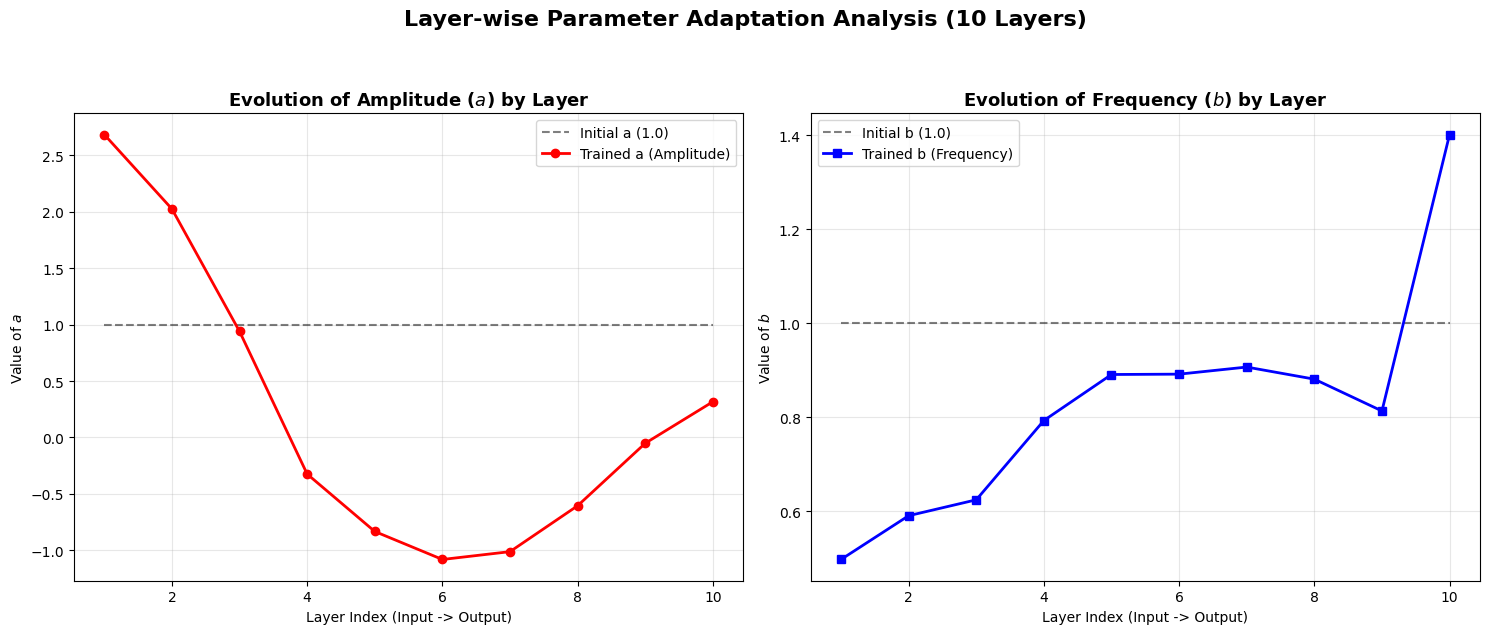

In [3]:
# ---------------------------------------------------------
# [1] 라이브러리 임포트 및 필수 구성 요소 정의
# ---------------------------------------------------------
import torch  # 파이토치: 모델 구성 및 학습 엔진
import torch.nn as nn  # 신경망 모듈
import torch.optim as optim  # 최적화 도구 (Adam)
import matplotlib.pyplot as plt  # 시각화: 파라미터 변화 그래프 작성
import numpy as np  # 수치 연산 및 배열 처리

# [주의] OscillatorySoftGate와 UniversalNet 클래스가 이전에 정의되어 있어야 합니다.
# (본 코드는 이전 셀의 클래스 정의를 그대로 사용한다고 가정합니다.)

# ---------------------------------------------------------
# [2] 계층별 파라미터 추출 함수 (Parameter Extractor)
# ---------------------------------------------------------
def get_layer_params(model):
    """
    모델의 각 층에 위치한 OscillatorySoftGate의 a, b 파라미터를 수집합니다.
    """
    a_values = [] # 각 층의 a 값을 담을 리스트
    b_values = [] # 각 층의 b 값을 담을 리스트
    
    # 모델의 모든 모듈을 순회하며 OscillatorySoftGate 층을 찾습니다.
    for name, module in model.named_modules():
        if isinstance(module, OscillatorySoftGate):
            # 학습 가능한 파라미터 a와 b의 현재 값을 CPU로 가져와 리스트에 추가합니다.
            a_values.append(module.a.item())
            b_values.append(module.b.item())
            
    return a_values, b_values

# ---------------------------------------------------------
# [3] 계층별 변화 관찰 실험 메인 루프
# ---------------------------------------------------------
def run_layer_evolution_experiment():
    # GPU 사용 가능 여부 확인 (RTX 3070 활용)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 분석용 데이터셋 로드 (CIFAR-10)
    train_loader, test_loader, in_dim, n_classes = get_dataset_config('CIFAR10', batch_size=128)
    
    # 깊은 분석을 위해 10층(Layers)으로 모델을 구성합니다.
    num_layers = 10 
    model = UniversalNet('oscillatory', in_dim, n_classes, num_layers=num_layers).to(device)
    
    # 1. 학습 전 초기 파라미터 상태 기록
    init_a, init_b = get_layer_params(model)
    
    # 2. 모델 학습 (파라미터가 수렴할 수 있도록 15 에포크 정도 수행)
    print(f"🚀 Training for Layer-wise Analysis (Layers: {num_layers})...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(15):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss = criterion(model(data), target)
            loss.backward()
            optimizer.step()
        print(f"   Epoch {epoch+1}/15 complete.")

    # 3. 학습 후 최종 파라미터 상태 기록
    final_a, final_b = get_layer_params(model)
    
    # ---------------------------------------------------------
    # [4] 결과 시각화 (Layer-wise Evolution Plot)
    # ---------------------------------------------------------
    layers = np.arange(1, len(final_a) + 1) # X축: 레이어 번호 (1, 2, ..., 10)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # (그래프 1) 진폭 a의 계층별 변화
    ax1.plot(layers, init_a, 'k--', label='Initial a (1.0)', alpha=0.5) # 초기값은 점선
    ax1.plot(layers, final_a, 'r-o', linewidth=2, label='Trained a (Amplitude)')
    ax1.set_title("Evolution of Amplitude ($a$) by Layer", fontsize=13, weight='bold')
    ax1.set_xlabel("Layer Index (Input -> Output)")
    ax1.set_ylabel("Value of $a$")
    ax1.legend(); ax1.grid(True, alpha=0.3)

    # (그래프 2) 주파수 b의 계층별 변화
    ax2.plot(layers, init_b, 'k--', label='Initial b (1.0)', alpha=0.5)
    ax2.plot(layers, final_b, 'b-s', linewidth=2, label='Trained b (Frequency)')
    ax2.set_title("Evolution of Frequency ($b$) by Layer", fontsize=13, weight='bold')
    ax2.set_xlabel("Layer Index (Input -> Output)")
    ax2.set_ylabel("Value of $b$")
    ax2.legend(); ax2.grid(True, alpha=0.3)

    plt.suptitle(f"Layer-wise Parameter Adaptation Analysis ({num_layers} Layers)", fontsize=16, weight='bold', y=1.05)
    plt.tight_layout()
    plt.savefig('layer_evolution_analysis.png', dpi=300)
    plt.show()

# 실험 실행
run_layer_evolution_experiment()